# Projekt Autoenkoder
Indeks: 145317

Wymagania:
- stworzenie sieci neuronowej typu autoencoder
- dane wejściowe to obrazy czarno-białe (1 kanał)
- dane wyjściowe to obrazy kolorowe (3 kanały)
- badanie różnych rozmiarów sieci neuronowej
- badanie wpływu poszczególnych elementów regularyzacji na wynik:
  - wpływ parametru momentum oraz rozmiaru batcha przy wykorzystaniu batch normalization
  - wpływ dropout rate
  - wpływ weight decay

Zrealizowane przy wykorzystaniu bibliotek:
- Pytorch — Tworzenie i nauka sieci neuronowej.
- Matplotlib -- Wizualizacja.
- cv2 - open-cv -- Obróbka obrazów.

Wykorzystany dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.


## Preludium

In [2]:
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar100
from keras import Sequential

import cv2
import numpy as np
import matplotlib.pyplot as plt

## Sprawdzenie dostępności GPU

In [3]:
import tensorflow as tf

print(
  gpus := tf.config.list_physical_devices('GPU'),
  gpus and 'GPU is available' or "GPU is not available"
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] GPU is available


## Załadowanie bazy obrazów Cifar100 oraz wykonanie preprocesów.
- Baza obrazów:
  - [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.
- Preprocesy:
  - Zamiana przestrzeni z 1-255 python-int na 0-1 float32.
  - Zamiana obrazu kolorowego na obraz szary.
  - Rozszerzenie kształtu obrazu szarego na kształt kompatybilny z wejściem sieci.

In [4]:
def rgb2gray(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def load_datasets():
  print("Loading train dataset...")
  print("Loading test dataset...")
  (y_train, _), (y_test, _) = cifar100.load_data()
  print("Preparing train dataset...")
  y_train = y_train.astype('float32') / 255
  x_train = np.expand_dims([rgb2gray(x) for x in y_train], axis=3)
  print("Preparing test dataset...")
  y_test = y_test.astype('float32') / 255
  x_test = np.expand_dims([rgb2gray(x) for x in y_test], axis=3)
  print("Finished.")
  return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_datasets()

Loading train dataset...
Loading test dataset...
Preparing train dataset...
Preparing test dataset...
Finished.


## Prezentacja przykładowych obrazów z datasetu.

In [5]:
def compare(original, grayscale=None):
  if grayscale is None: grayscale = rgb2gray(original)

  figure, axes = plt.subplots(1, 2)
  axes[0].set_title("Original")
  axes[0].grid(False)
  axes[0].set_axis_off()
  axes[0].imshow(original)
  axes[1].set_title("Grayscale")
  axes[1].grid(False)
  axes[1].set_axis_off()
  axes[1].imshow(grayscale, cmap='gray')

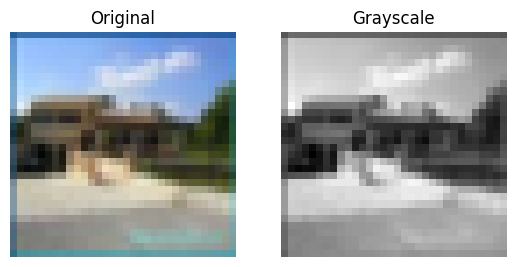

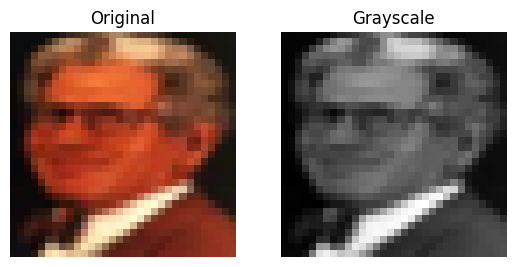

In [6]:
index = np.random.randint(2, len(y_train) - 1)
for original in y_train[index - 2:index]: compare(original)

### Prezentacja kolażu obrazów.

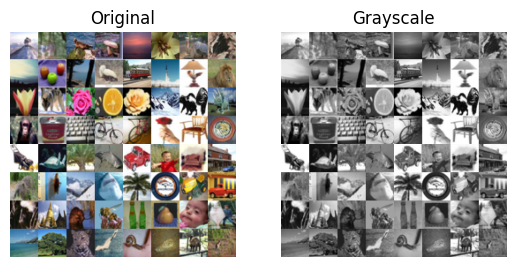

In [7]:
def square_collage(images, size: int = 8):
  (_, rows, cols, channels) = images.shape
  collage = images[:size * size]
  collage = collage.reshape((size, size, rows, cols, channels))
  return np.vstack([*map(np.hstack, collage)])

compare(square_collage(y_test), square_collage(x_test))

## Konstrukcja modelu sieci autoencoder.
- Konstrukcja sieci jst sparametryzowana o możliwość wprowadzenia:
  - use_normalization: bool -- batch normalization.
  - use_dropout: bool | float -- wykorzystanie dropout'u.
- Podczas trenowania sieci również są dostępne opcje:
  - use_weight_decay: float -- wykorzystanie weight decay podczas nauki.

### Model 'Encoder'.

In [8]:
class Encoder(Model):
  def __init__(self, layers_filters, use_normalization=False, use_dropout=False):
    super().__init__(name='encoder')
    def layers():
      for filters in layers_filters:
        yield Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        if use_normalization:
          yield BatchNormalization()
        if use_dropout:
          yield Dropout(use_dropout)
    self.net = Sequential(list(layers()))

  def call(self, inputs):
    return self.net(inputs)

### Model 'Decoder'.

In [9]:
class Decoder(Model):
  def __init__(self, layers_filters):
    super().__init__(name='decoder')
    def layers():
      for filters in reversed(layers_filters):
        yield Conv2DTranspose(filters, kernel_size=3, padding='same', activation='relu')
      yield Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')

    self.net = Sequential(list(layers()))

  def call(self, inputs):
    return self.net(inputs)


### Podsumowanie enkodera i dekodera

In [10]:
layers_filters = [32, 64, 128, 256]
encoder = Decoder(layers_filters)
encoder.build(input_shape=(None, None, None, 1))
encoder.summary()
decoder = Encoder(layers_filters)
decoder.build(input_shape=(None, None, None, 3))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     390723    
                                                                 
Total params: 390,723
Trainable params: 390,723
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, None, None, 256)   388416    
                                                                 
Total params: 388,416
Trainable params: 388,416
Non-trainable params: 0
_________________________________________________________________


### Podsumowanie autoenkodera

In [11]:
class Autoencoder(Model):
  def __init__(self, layers_filters, use_normalization=False, use_dropout=False):
    super().__init__(name='autoencoder')
    def layers():
      yield Encoder(layers_filters, use_normalization, use_dropout)
      yield Decoder(layers_filters)
    self.net = Sequential(list(layers()))
  def call(self, inputs): return self.net(inputs)
autoencoder = Autoencoder(layers_filters)
autoencoder.build(input_shape=(None, None, None, 1))
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, None, 3)     1366083   
                                                                 
Total params: 1,366,083
Trainable params: 1,366,083
Non-trainable params: 0
_________________________________________________________________


### Training callbacks
- ReduceLROnPlateau - reduces lr by given value 0.1**0.5 every 3 epochs without improvement.
- ModalCheckpoint - saves model to given path every improved epoch.

### Training the network

In [12]:
import tensorflow_addons as tfa

def train_model(model, weight_decay=0, savename=None):
  callbacks = [
    ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6),
    ModelCheckpoint(filepath=f'models/{savename}.ckpt', monitor='val_loss', save_best_only=True)
  ]

  optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=weight_decay)

  model.compile(loss='mse', optimizer=optimizer)
  return model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs=20, batch_size=16, callbacks=callbacks)

histories = train_model(autoencoder)

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0099

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 65s 20ms/step - loss: 0.0099 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 19ms/step - loss: 0.0089 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 58s 19ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 20ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 5/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 19ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0084 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 19ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 20ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 0.0010
Epoch 11/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0079

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 20ms/step - loss: 0.0079 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 12/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.0079

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 19ms/step - loss: 0.0079 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0078 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 14/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 15/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: models\None.ckpt\assets


INFO:tensorflow:Assets written to: models\None.ckpt\assets


3125/3125 [==============================] - 61s 20ms/step - loss: 0.0076 - val_loss: 0.0080 - lr: 1.0000e-04
Epoch 16/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 17/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 19/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [==============================] - 59s 19ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 3.1623e-05


### Predict using autoencoder

In [13]:
predicted = autoencoder.predict(x_test)

313/313 [==============================] - 4s 9ms/step


## Results side by side
### Multiple

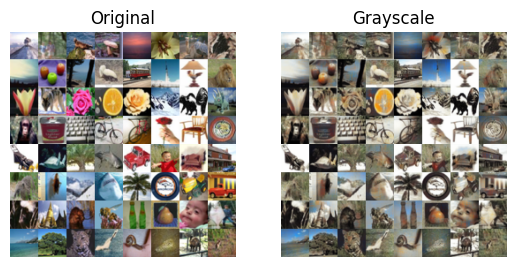

In [14]:
compare(square_collage(y_test), square_collage(predicted))

### Single Image

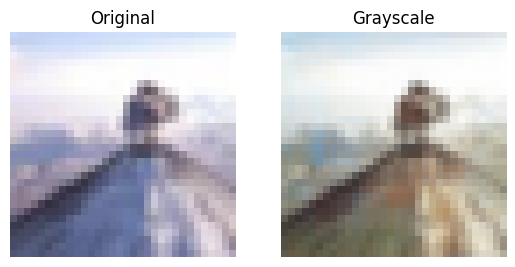

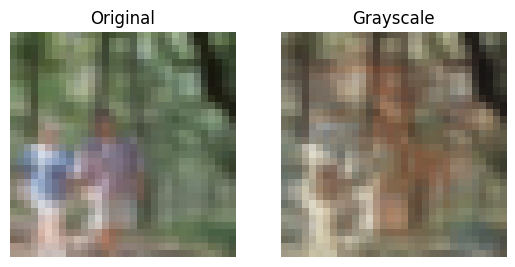

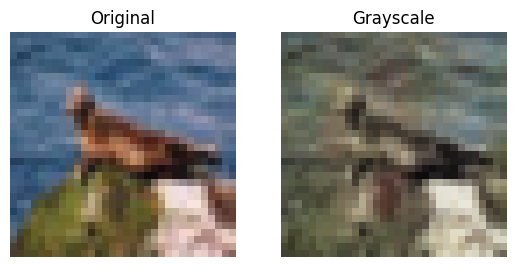

In [15]:
for (original, prediction) in zip(y_test[:3], predicted[:3]): compare(original, prediction)

## Badania wpływu parametrów na wyjście i parametry walidujące.
Sieć kontrolna to:
Sieć bez dropout, bez normalizacji batch'y, bez weight decay oraz o rozmiarze filtrów warstw [64, 128, 256, 512]

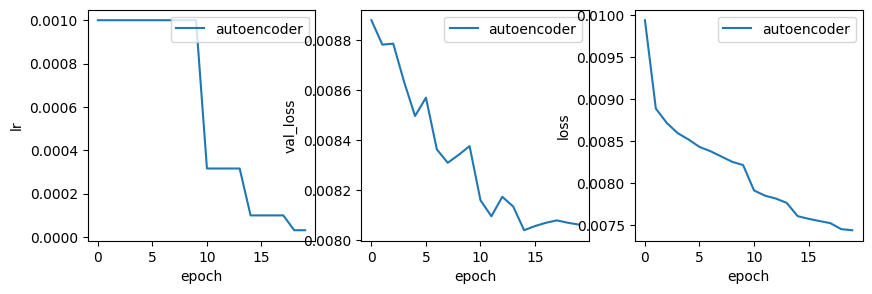

In [16]:
def plot_histories(*pairs, parameters):
  figure, axes = plt.subplots(ncols=len(parameters), figsize=(10, 3))
  (models, histories) = list(zip(*pairs))

  labels = [x.name for x in models]
  for axis, parameter in zip(axes.reshape(-1), parameters):
    for history in histories:
      axis.plot(history.history[parameter])
    axis.set_ylabel(parameter)
    axis.set_xlabel('epoch')
    axis.legend(labels, loc='upper right')
  plt.show()

# Przykładowy plot z parametrami learning_rate, val_loss oraz loss
plot_histories((autoencoder, histories), parameters=['lr', 'val_loss', 'loss'])

### Wpływ dropout rate.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.05
  - Sieć III -- 0.15

Epoch 1/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0099

INFO:tensorflow:Assets written to: models\dropout-0.00.001.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.001.ckpt\assets


3125/3125 [==============================] - 166s 52ms/step - loss: 0.0099 - val_loss: 0.0093 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\dropout-0.00.002.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.002.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0089 - val_loss: 0.0090 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\dropout-0.00.003.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.003.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\dropout-0.00.004.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.004.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0086 - val_loss: 0.0087 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\dropout-0.00.005.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.005.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0084 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\dropout-0.00.007.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.007.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\dropout-0.00.008.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.008.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 0.0010
Epoch 10/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\dropout-0.00.010.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.010.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 0.0010
Epoch 11/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 0.0010
Epoch 12/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\dropout-0.00.012.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.012.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0078 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 14/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\dropout-0.00.014.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.00.014.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 15/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 16/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 17/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 19/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0073 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0103

INFO:tensorflow:Assets written to: models\dropout-0.05.001.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.001.ckpt\assets


3125/3125 [==============================] - 171s 55ms/step - loss: 0.0103 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0090

INFO:tensorflow:Assets written to: models\dropout-0.05.002.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.002.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0090 - val_loss: 0.0087 - lr: 0.0010
Epoch 3/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0088

INFO:tensorflow:Assets written to: models\dropout-0.05.003.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.003.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0088 - val_loss: 0.0087 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0087 - val_loss: 0.0087 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\dropout-0.05.005.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.005.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0085 - val_loss: 0.0086 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0081

INFO:tensorflow:Assets written to: models\dropout-0.05.009.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.009.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0081 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 10/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0081

INFO:tensorflow:Assets written to: models\dropout-0.05.010.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.010.ckpt\assets


3125/3125 [==============================] - 168s 54ms/step - loss: 0.0081 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 11/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0080 - val_loss: 0.0083 - lr: 3.1623e-04
Epoch 12/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0080 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\dropout-0.05.013.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.013.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 14/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 15/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 16/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\dropout-0.05.016.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.016.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 17/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: models\dropout-0.05.017.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.05.017.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 18/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 19/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 1.0000e-05
Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0104

INFO:tensorflow:Assets written to: models\dropout-0.15.001.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.001.ckpt\assets


3125/3125 [==============================] - 171s 55ms/step - loss: 0.0104 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0091

INFO:tensorflow:Assets written to: models\dropout-0.15.002.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.002.ckpt\assets


3125/3125 [==============================] - 170s 54ms/step - loss: 0.0091 - val_loss: 0.0087 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0090 - val_loss: 0.0090 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\dropout-0.15.004.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.004.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0088 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\dropout-0.15.006.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.006.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 3.1623e-04
Epoch 7/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 8/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\dropout-0.15.008.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.008.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 3.1623e-04
Epoch 9/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0082 - val_loss: 0.0085 - lr: 3.1623e-04
Epoch 10/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0081

INFO:tensorflow:Assets written to: models\dropout-0.15.010.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.010.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0081 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 11/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 12/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 13/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0080

INFO:tensorflow:Assets written to: models\dropout-0.15.013.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.013.ckpt\assets


3125/3125 [==============================] - 170s 54ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 14/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0079

INFO:tensorflow:Assets written to: models\dropout-0.15.014.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.014.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0079 - val_loss: 0.0080 - lr: 3.1623e-05
Epoch 15/20
3125/3125 [==============================] - 166s 53ms/step - loss: 0.0079 - val_loss: 0.0080 - lr: 3.1623e-05
Epoch 16/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0079 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 17/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0079

INFO:tensorflow:Assets written to: models\dropout-0.15.017.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.017.ckpt\assets


3125/3125 [==============================] - 169s 54ms/step - loss: 0.0079 - val_loss: 0.0080 - lr: 1.0000e-05
Epoch 18/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0079 - val_loss: 0.0080 - lr: 1.0000e-05
Epoch 19/20
3125/3125 [==============================] - 167s 53ms/step - loss: 0.0078 - val_loss: 0.0080 - lr: 1.0000e-05
Epoch 20/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\dropout-0.15.020.ckpt\assets


INFO:tensorflow:Assets written to: models\dropout-0.15.020.ckpt\assets


3125/3125 [==============================] - 170s 54ms/step - loss: 0.0078 - val_loss: 0.0080 - lr: 3.1623e-06


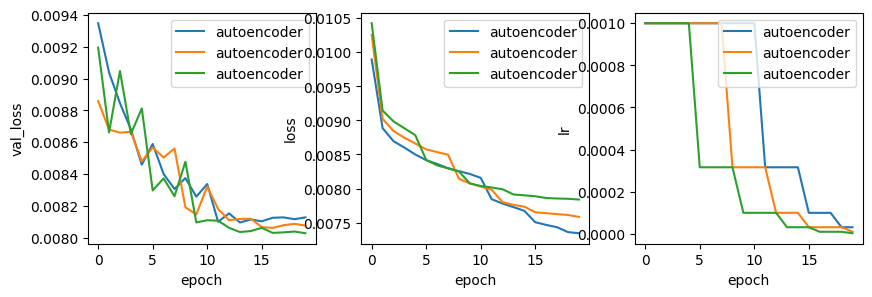

In [17]:
layers = [64, 128, 256, 512]
dropout_model_base = Autoencoder(layers, use_dropout=0.00)
dropout_model_1 = Autoencoder(layers, use_dropout=0.05)
dropout_model_2 = Autoencoder(layers, use_dropout=0.15)

dropout_model_base.build(input_shape=(None, None, None, 1))
dropout_model_1.build(input_shape=(None, None, None, 1))
dropout_model_2.build(input_shape=(None, None, None, 1))

dropout_pairs = [
  (dropout_model_base, train_model(dropout_model_base, savename='dropout-0.00.{epoch:03d}')),
  (dropout_model_1, train_model(dropout_model_1, savename='dropout-0.05.{epoch:03d}')),
  (dropout_model_2, train_model(dropout_model_2, savename='dropout-0.15.{epoch:03d}')),
]
plot_histories(*dropout_pairs, parameters=['val_loss', 'loss', 'lr'])

313/313 [==============================] - 9s 27ms/step


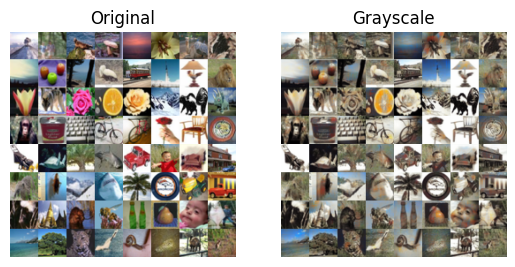

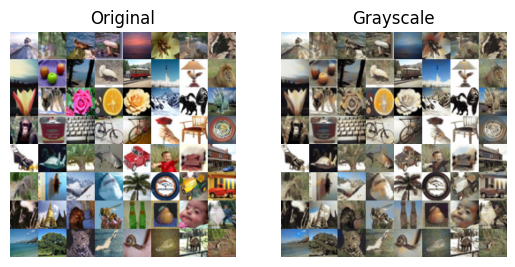

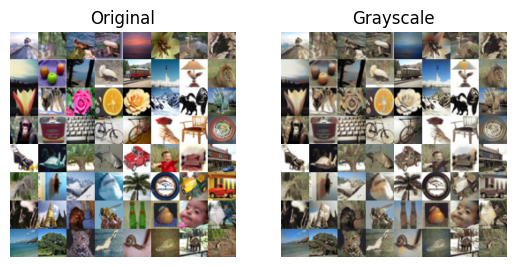

In [18]:
predicted = dropout_model_base.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = dropout_model_1.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = dropout_model_2.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))


### Wpływ weight decay.
- Do badania został wykorzystany rozszerzenie AdamW optymalizator Adama.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.10
  - Sieć III -- 0.25

Epoch 1/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0100

INFO:tensorflow:Assets written to: models\decay-0.00.001.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.001.ckpt\assets


3125/3125 [==============================] - 164s 52ms/step - loss: 0.0100 - val_loss: 0.0088 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\decay-0.00.002.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.002.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0089 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\decay-0.00.004.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.004.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\decay-0.00.005.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.005.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0083 - val_loss: 0.0086 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\decay-0.00.008.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.008.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0080

INFO:tensorflow:Assets written to: models\decay-0.00.009.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.009.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 10/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0079 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 11/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0079 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 12/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\decay-0.00.013.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.013.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 14/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 15/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0076

INFO:tensorflow:Assets written to: models\decay-0.00.015.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.00.015.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 16/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 17/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 18/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 19/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-05
Epoch 20/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-05
Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0721

INFO:tensorflow:Assets written to: models\decay-0.10.001.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.10.001.ckpt\assets


3125/3125 [==============================] - 158s 50ms/step - loss: 0.0721 - val_loss: 0.0726 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0722

INFO:tensorflow:Assets written to: models\decay-0.10.002.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.10.002.ckpt\assets


3125/3125 [==============================] - 156s 50ms/step - loss: 0.0722 - val_loss: 0.0725 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0722

INFO:tensorflow:Assets written to: models\decay-0.10.003.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.10.003.ckpt\assets


3125/3125 [==============================] - 157s 50ms/step - loss: 0.0722 - val_loss: 0.0724 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0722 - val_loss: 0.0725 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0722 - val_loss: 0.0725 - lr: 0.0010
Epoch 6/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0722

INFO:tensorflow:Assets written to: models\decay-0.10.006.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.10.006.ckpt\assets


3125/3125 [==============================] - 156s 50ms/step - loss: 0.0722 - val_loss: 0.0723 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0722 - val_loss: 0.0726 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0722 - val_loss: 0.0728 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0722 - val_loss: 0.0727 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 3.1623e-04
Epoch 11/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 3.1623e-04
Epoch 12/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 154s 49ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 1.0000e-04
Epoch 14/20
3125/3125 [========================

INFO:tensorflow:Assets written to: models\decay-0.25.001.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.25.001.ckpt\assets


3125/3125 [==============================] - 159s 51ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0724

INFO:tensorflow:Assets written to: models\decay-0.25.004.ckpt\assets


INFO:tensorflow:Assets written to: models\decay-0.25.004.ckpt\assets


3125/3125 [==============================] - 157s 50ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 3.1623e-04
Epoch 6/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0728 - lr: 3.1623e-04
Epoch 7/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 3.1623e-04
Epoch 8/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 1.0000e-04
Epoch 9/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 1.0000e-04
Epoch 10/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 1.0000e-04
Epoch 11/20
3125/3125 [==============================] - 155s 50ms/step - loss: 0.0724 - val_loss: 0.0729 - lr: 3.1623e-05
Epoch 12/20
3125/3125 [==============

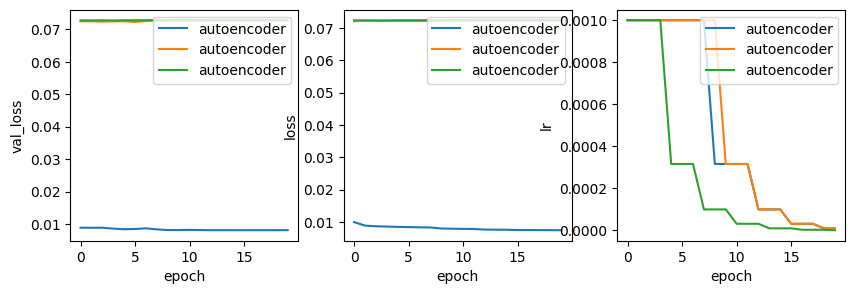

In [19]:
layers = [64, 128, 256, 512]
decay_model_base = Autoencoder(layers)
decay_model_1 = Autoencoder(layers)
decay_model_2 = Autoencoder(layers)

decay_model_base.build(input_shape=(None, None, None, 1))
decay_model_1.build(input_shape=(None, None, None, 1))
decay_model_2.build(input_shape=(None, None, None, 1))

decay_pairs = [
  (decay_model_base, train_model(decay_model_base, weight_decay=0.00, savename='decay-0.00.{epoch:03d}')),
  (decay_model_1, train_model(decay_model_1, weight_decay=0.10, savename='decay-0.10.{epoch:03d}')),
  (decay_model_2, train_model(decay_model_2, weight_decay=0.25, savename='decay-0.25.{epoch:03d}'))
]
plot_histories(*decay_pairs, parameters=['val_loss', 'loss', 'lr'])

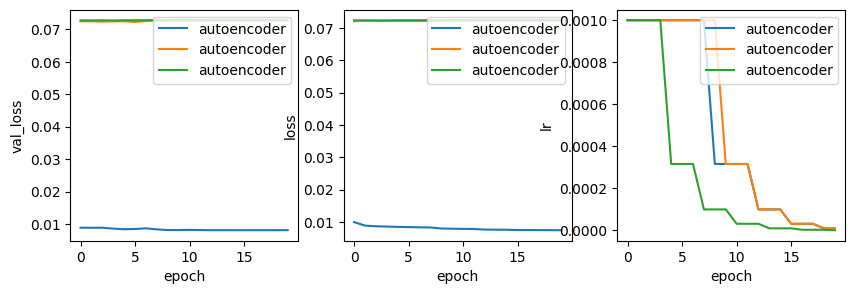

313/313 [==============================] - 8s 26ms/step


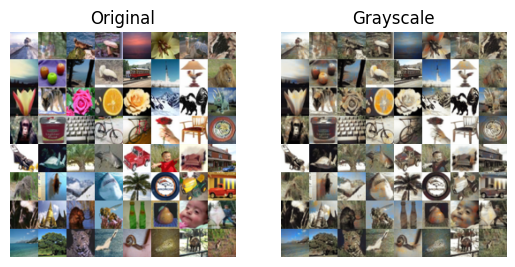

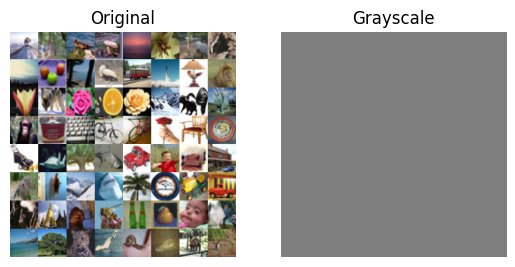

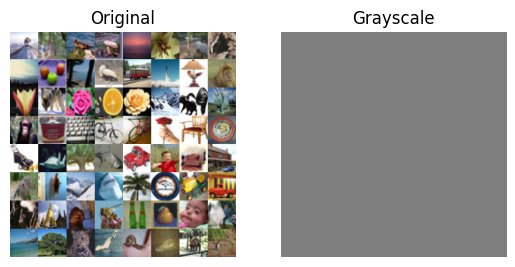

In [20]:
plot_histories(*decay_pairs, parameters=['val_loss', 'loss', 'lr'])
predicted = decay_model_base.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = decay_model_1.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = decay_model_2.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))

### Wpływ rozmiaru batch normalization.
- Do badania została wykorzystana gotowa wartswa z tensorflow.keras BatchNormalization.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- istnieje

In [21]:
layers = [64, 128, 256, 512]
batch_model_no = Autoencoder(layers, use_normalization=False)
batch_model_yes = Autoencoder(layers, use_normalization=True)

batch_model_no.build(input_shape=(None, None, None, 1))
batch_model_yes.build(input_shape=(None, None, None, 1))

batch_pairs = [
  (batch_model_no, train_model(batch_model_no, savename='batch-no.{epoch:03d}')),
  (batch_model_yes, train_model(batch_model_yes, savename='batch-yes.{epoch:03d}'))
]

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0098

INFO:tensorflow:Assets written to: models\batch-no.001.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.001.ckpt\assets


3125/3125 [==============================] - 165s 53ms/step - loss: 0.0098 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\batch-no.002.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.002.ckpt\assets


3125/3125 [==============================] - 163s 52ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\batch-no.003.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.003.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 5/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\batch-no.005.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.005.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0085 - val_loss: 0.0084 - lr: 0.0010
Epoch 6/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\batch-no.006.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.006.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\batch-no.007.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.007.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0084 - val_loss: 0.0083 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\batch-no.008.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.008.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 0.0010
Epoch 11/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0081 - val_loss: 0.0084 - lr: 0.0010
Epoch 12/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\batch-no.012.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-no.012.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 14/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0077 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 15/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 16/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 17/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 19/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0073 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [=====

INFO:tensorflow:Assets written to: models\batch-yes.001.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.001.ckpt\assets


3125/3125 [==============================] - 182s 58ms/step - loss: 0.0112 - val_loss: 0.0095 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0092

INFO:tensorflow:Assets written to: models\batch-yes.002.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.002.ckpt\assets


3125/3125 [==============================] - 179s 57ms/step - loss: 0.0092 - val_loss: 0.0090 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\batch-yes.003.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.003.ckpt\assets


3125/3125 [==============================] - 179s 57ms/step - loss: 0.0089 - val_loss: 0.0089 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0088 - val_loss: 0.0095 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\batch-yes.005.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.005.ckpt\assets


3125/3125 [==============================] - 179s 57ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\batch-yes.006.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.006.ckpt\assets


3125/3125 [==============================] - 178s 57ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0085 - val_loss: 0.0088 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 176s 56ms/step - loss: 0.0084 - val_loss: 0.0088 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\batch-yes.009.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.009.ckpt\assets


3125/3125 [==============================] - 178s 57ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0083 - val_loss: 0.0087 - lr: 0.0010
Epoch 11/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\batch-yes.011.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.011.ckpt\assets


3125/3125 [==============================] - 179s 57ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 0.0010
Epoch 12/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0081 - val_loss: 0.0085 - lr: 0.0010
Epoch 13/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\batch-yes.013.ckpt\assets


INFO:tensorflow:Assets written to: models\batch-yes.013.ckpt\assets


3125/3125 [==============================] - 178s 57ms/step - loss: 0.0077 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 14/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0076 - val_loss: 0.0083 - lr: 3.1623e-04
Epoch 15/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0074 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 16/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0073 - val_loss: 0.0086 - lr: 3.1623e-04
Epoch 17/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0069 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0068 - val_loss: 0.0085 - lr: 1.0000e-04
Epoch 19/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0067 - val_loss: 0.0086 - lr: 1.0000e-04
Epoch 20/20
3125/3125 [==============================] - 175s 56ms/step - loss: 0.0065 - val_loss: 0.0087 - lr: 3.1623e-05


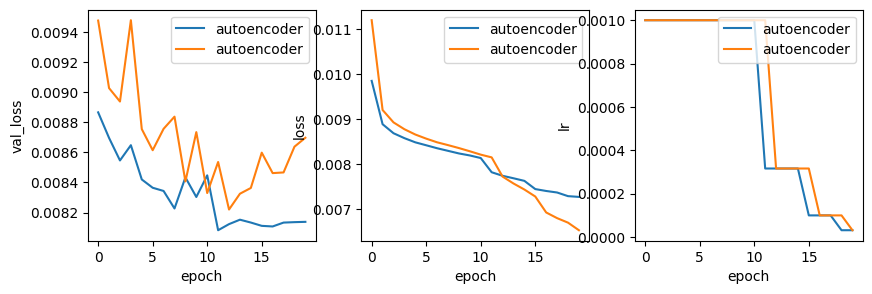

313/313 [==============================] - 9s 27ms/step


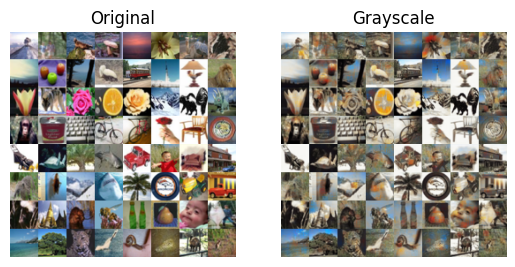

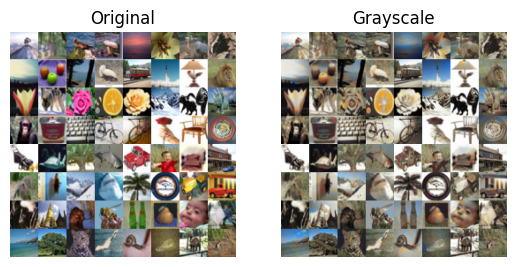

In [22]:
plot_histories(*batch_pairs, parameters=['val_loss', 'loss', 'lr'])
predicted = batch_model_yes.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = batch_model_no.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))

### Wpływ rozmiaru sieci.
- Do badania została wykorzystana gotowa wartswy z paczki tensorflow.keras.
- badane sieci:
  - Sieć I   -- Kontrolna | [64, 128, 256, 512]
  - Sieć II  -- [32, 64, 128, 512, 512]
  - Sieć III -- [32, 64]

In [23]:
filters_model_base = Autoencoder([64, 128, 256, 512])
filters_model_1 = Autoencoder([32, 64, 128, 512, 512])
filters_model_2 = Autoencoder([32, 64])

filters_model_base.build(input_shape=(None, None, None, 1))
filters_model_1.build(input_shape=(None, None, None, 1))
filters_model_2.build(input_shape=(None, None, None, 1))

filters_pairs = [
  (filters_model_base, train_model(filters_model_base, savename='filters-medium.{epoch:03d}')),
  (filters_model_1, train_model(filters_model_1, savename='filters-bigger.{epoch:03d}')),
  (filters_model_2, train_model(filters_model_2, savename='filters-smaller.{epoch:03d}')),
]

Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0103

INFO:tensorflow:Assets written to: models\filters-medium.001.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.001.ckpt\assets


3125/3125 [==============================] - 164s 52ms/step - loss: 0.0103 - val_loss: 0.0090 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0088

INFO:tensorflow:Assets written to: models\filters-medium.002.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.002.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0088 - val_loss: 0.0086 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\filters-medium.003.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.003.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0087 - val_loss: 0.0085 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\filters-medium.004.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.004.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\filters-medium.005.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.005.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\filters-medium.006.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.006.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 7/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: models\filters-medium.007.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.007.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\filters-medium.008.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.008.ckpt\assets


3125/3125 [==============================] - 161s 51ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\filters-medium.009.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.009.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0083 - val_loss: 0.0082 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0082 - val_loss: 0.0084 - lr: 0.0010
Epoch 11/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-medium.011.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.011.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 0.0010
Epoch 12/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0079

INFO:tensorflow:Assets written to: models\filters-medium.012.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.012.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0079 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\filters-medium.013.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.013.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0078 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 14/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\filters-medium.014.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.014.ckpt\assets


3125/3125 [==============================] - 161s 52ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 15/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 16/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0075

INFO:tensorflow:Assets written to: models\filters-medium.016.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-medium.016.ckpt\assets


3125/3125 [==============================] - 162s 52ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 17/20
3125/3125 [==============================] - 159s 51ms/step - loss: 0.0075 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 19/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [==============================] - 160s 51ms/step - loss: 0.0074 - val_loss: 0.0081 - lr: 3.1623e-05
Epoch 1/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0102

INFO:tensorflow:Assets written to: models\filters-bigger.001.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.001.ckpt\assets


3125/3125 [==============================] - 237s 75ms/step - loss: 0.0102 - val_loss: 0.0091 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0089

INFO:tensorflow:Assets written to: models\filters-bigger.002.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.002.ckpt\assets


3125/3125 [==============================] - 234s 75ms/step - loss: 0.0089 - val_loss: 0.0087 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 232s 74ms/step - loss: 0.0087 - val_loss: 0.0089 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\filters-bigger.004.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.004.ckpt\assets


3125/3125 [==============================] - 235s 75ms/step - loss: 0.0086 - val_loss: 0.0085 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 232s 74ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0084 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\filters-bigger.007.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.007.ckpt\assets


3125/3125 [==============================] - 233s 75ms/step - loss: 0.0083 - val_loss: 0.0083 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 232s 74ms/step - loss: 0.0083 - val_loss: 0.0085 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0082 - val_loss: 0.0085 - lr: 0.0010
Epoch 10/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 0.0010
Epoch 11/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: models\filters-bigger.011.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.011.ckpt\assets


3125/3125 [==============================] - 234s 75ms/step - loss: 0.0078 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 12/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0077

INFO:tensorflow:Assets written to: models\filters-bigger.012.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-bigger.012.ckpt\assets


3125/3125 [==============================] - 234s 75ms/step - loss: 0.0077 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 232s 74ms/step - loss: 0.0076 - val_loss: 0.0081 - lr: 3.1623e-04
Epoch 14/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0075 - val_loss: 0.0082 - lr: 3.1623e-04
Epoch 15/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0073 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 16/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0072 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 17/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0071 - val_loss: 0.0082 - lr: 1.0000e-04
Epoch 18/20
3125/3125 [==============================] - 231s 74ms/step - loss: 0.0070 - val_loss: 0.0082 - lr: 3.1623e-05
Epoch 19/20
3125/3125 [==============================] - 230s 74ms/step - loss: 0.0070 - val_loss: 0.0082 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [=====

INFO:tensorflow:Assets written to: models\filters-smaller.001.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.001.ckpt\assets


3125/3125 [==============================] - 16s 5ms/step - loss: 0.0100 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/20
3123/3125 [============================>.] - ETA: 0s - loss: 0.0090

INFO:tensorflow:Assets written to: models\filters-smaller.002.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.002.ckpt\assets


3125/3125 [==============================] - 16s 5ms/step - loss: 0.0090 - val_loss: 0.0089 - lr: 0.0010
Epoch 3/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.0088

INFO:tensorflow:Assets written to: models\filters-smaller.003.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.003.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0088 - val_loss: 0.0088 - lr: 0.0010
Epoch 4/20
3119/3125 [============================>.] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\filters-smaller.004.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.004.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 5/20
3122/3125 [============================>.] - ETA: 0s - loss: 0.0087

INFO:tensorflow:Assets written to: models\filters-smaller.005.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.005.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0086 - val_loss: 0.0087 - lr: 0.0010
Epoch 6/20
3119/3125 [============================>.] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\filters-smaller.006.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.006.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 7/20
3114/3125 [============================>.] - ETA: 0s - loss: 0.0086

INFO:tensorflow:Assets written to: models\filters-smaller.007.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.007.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0086 - val_loss: 0.0086 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0085 - val_loss: 0.0086 - lr: 0.0010
Epoch 9/20
3120/3125 [============================>.] - ETA: 0s - loss: 0.0085

INFO:tensorflow:Assets written to: models\filters-smaller.009.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.009.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0085 - val_loss: 0.0085 - lr: 0.0010
Epoch 10/20
3112/3125 [============================>.] - ETA: 0s - loss: 0.0083

INFO:tensorflow:Assets written to: models\filters-smaller.010.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.010.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 11/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 12/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 13/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0083 - val_loss: 0.0084 - lr: 3.1623e-04
Epoch 14/20
3117/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.014.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.014.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 15/20
3118/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.015.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.015.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 16/20
3125/3125 [==============================] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.016.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.016.ckpt\assets


3125/3125 [==============================] - 16s 5ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 1.0000e-04
Epoch 17/20
3117/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.017.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.017.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0083 - lr: 3.1623e-05
Epoch 18/20
3116/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.018.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.018.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 3.1623e-05
Epoch 19/20
3124/3125 [============================>.] - ETA: 0s - loss: 0.0082

INFO:tensorflow:Assets written to: models\filters-smaller.019.ckpt\assets


INFO:tensorflow:Assets written to: models\filters-smaller.019.ckpt\assets


3125/3125 [==============================] - 15s 5ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 3.1623e-05
Epoch 20/20
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 3.1623e-05


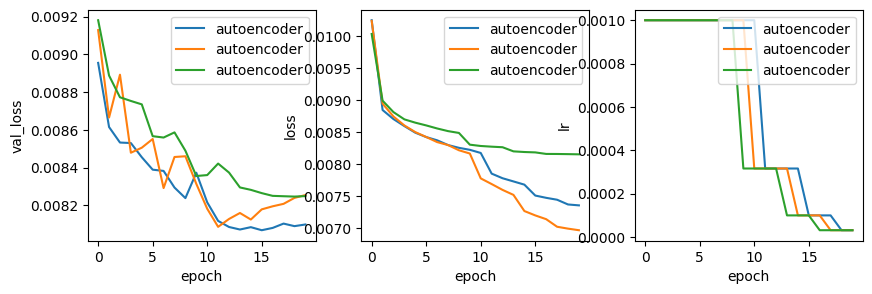

313/313 [==============================] - 1s 2ms/step


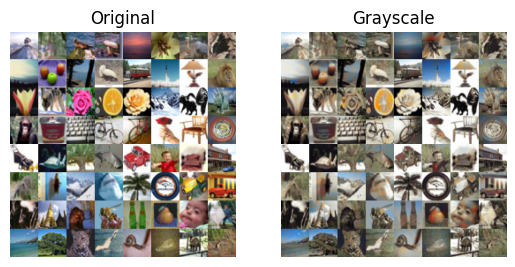

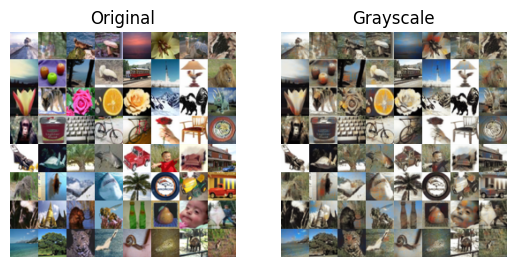

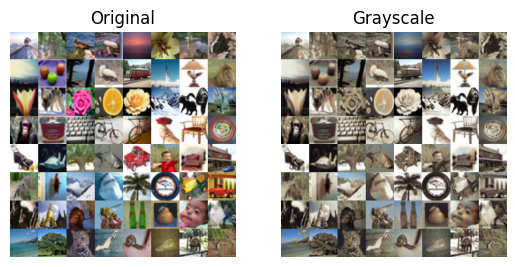

In [24]:
plot_histories(*filters_pairs, parameters=['val_loss', 'loss', 'lr'])
predicted = filters_model_base.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = filters_model_1.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))
predicted = filters_model_2.predict(x_test)
compare(square_collage(y_test), square_collage(predicted))

## Podsumowanie oraz Doświadczenia
- Tensorflow jest wstrętną technologią.
- w tym wypadku jakikolwiek decay wplywa negatywnie na jakość obrazów.
- Możliwym rozwiązaniem jest większa sieć.
- Zmiana architektury bardziej zbliżona do współczesnych modeli jak novel ai, protogen etc. [civilai](https://civitai.com/)
- Niestety weight_decay powoduje całkowitą szarość obrazów i nie potrafię zobaczyć, dlaczego sieć ma takiego alzheimera.
